In [ ]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master
!git clone https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d.git (to revision master) to /tmp/pip-req-build-jgtb742f
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d.git /tmp/pip-req-build-jgtb742f

  Resolved https://github.com/greydanus/mnist1d.git to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
fatal: destination path 'mnist1d' already exists and is not an empty directory.


⚡️ Tip	Connect GitHub to Studios: https://lightning.ai/akshatodiya79-7unu8/home?settings=integrations



In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.ndimage import gaussian_filter
import torch.optim as optim
import matplotlib.pylab as pl
import torch, os,time
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import mnist1d

In [ ]:
%matplotlib inline

import pylab as plt
import numpy as np

In [ ]:
from mnist1d.data import get_dataset, get_dataset_args
from mnist1d.utils import set_seed, to_pickle, from_pickle

import sys ; sys.path.append('/teamspace/studios/this_studio/mnist1d/notebooks')
from train import get_model_args, train_model

In [ ]:
args = get_dataset_args()
data = get_dataset(args=args)

File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl


In [ ]:
class SparseLinear(torch.nn.Module):
  def __init__(self, x_size, y_size):
    super(SparseLinear, self).__init__()
    self.linear = torch.nn.Linear(x_size, y_size)
    param_vec = torch.cat([p.flatten() for p in self.parameters()])
    self.mask = torch.ones_like(param_vec)

  def forward(self, x, apply_mask=True):
    if apply_mask:
      self.apply_mask()
    return self.linear(x)

  def update_mask(self, new_mask):
    self.mask = new_mask
    self.apply_mask()

  def apply_mask(self):
    self.vec2param(self.param2vec())

  def param2vec(self):
    vec = torch.cat([p.flatten() for p in self.parameters()])
    return self.mask * vec

  def vec2param(self, vec):
    pointer = 0
    for param in self.parameters():
      param_len = np.cumprod(param.shape)[-1]
      new_param = vec[pointer:pointer+param_len].reshape(param.shape)
      param.data = new_param.data
      pointer += param_len

class SparseMLP(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(SparseMLP, self).__init__()
    self.linear1 = SparseLinear(input_size, hidden_size)
    self.linear2 = SparseLinear(hidden_size, hidden_size)
    self.linear3 = SparseLinear(hidden_size, output_size)
    self.layers = [self.linear1, self.linear2, self.linear3]

  def forward(self, x):
    h = torch.relu(self.linear1(x))
    h = h + torch.relu(self.linear2(h))
    h = self.linear3(h)
    return h

  def get_layer_masks(self):
    return [l.mask for l in self.layers]

  def set_layer_masks(self, new_masks):
    for i, l in enumerate(self.layers):
      l.update_mask(new_masks[i])

  def get_layer_vecs(self):
    return [l.param2vec() for l in self.layers]

  def set_layer_vecs(self, vecs):
    for i, l in enumerate(self.layers):
      l.vec2param(vecs[i])

In [ ]:
def get_mask(scores, percent_sparse):

    # Calculate the number of weights to drop
    num_to_drop = int(percent_sparse * scores.numel())

    # Get the indices of weights with the lowest scores
    ixs_to_drop = torch.argsort(scores)[:num_to_drop]  # Sort by score, select lowest `num_to_drop` scores

    # Initialize the mask with ones (retain all initially)
    mask = torch.ones_like(scores)

    # Set indices of lowest-scored weights to 0
    mask[ixs_to_drop] = 0

    return mask


In [ ]:
def find_lottery_ticket(model, dataset, args, sparsity_schedule, criteria_fn=None,
                        prune_print_every=None, **kwargs):
  if prune_print_every is None:
    prune_print_every = np.inf

  if criteria_fn is None:
    print("Using default magnitude-based pruning")
    criteria_fn = lambda init_params, final_params: final_params.abs()

  init_params = model.get_layer_vecs()
  stats = {'train_losses':[], 'test_losses':[], 'train_accs':[], 'test_accs':[]}
  models = []
  for i, percent_sparse in enumerate(sparsity_schedule):

    # layer-wise pruning, where pruning heuristic is determined by criteria_fn
    final_params = model.get_layer_vecs()
    scores = [criteria_fn(ip, fp) for ip, fp in zip(init_params, final_params)]
    masks = [get_mask(s, percent_sparse) for s in scores]

    # update model with mask and init parameters
    model.set_layer_vecs(init_params)
    model.set_layer_masks(masks)

    # training process
    results = train_model(dataset, model, args)
    model = results['checkpoints'][-1]

    # store stats
    stats['train_losses'].append(results['train_losses'])
    stats['test_losses'].append(results['test_losses'])
    stats['train_accs'].append(results['train_acc'])
    stats['test_accs'].append(results['test_acc'])

    # print progress
    if (i+1) % prune_print_every == 0:
      print('\tretrain #{}, sparsity {:.2f}, final_train_loss {:.3e}, max_acc {:.1f}, last_acc {:.1f}, mean_acc {:.1f}'
            .format(i+1, percent_sparse, results['train_losses'][-1], np.max(results['test_acc']),
            results['test_acc'][-1], np.mean(results['test_acc']) ))
      models.append(copy.deepcopy(model))

  stats = {k: np.stack(v) for k, v in stats.items()}
  return models, stats

In [ ]:
# train settings
model_args = get_model_args()
model_args.total_steps = 1501
model_args.hidden_size = 500
model_args.print_every = 5000
model_args.eval_every = 100
#model_args.learning_rate = 2e-2


# sparsity settings
num_retrains = 100
sparsity_schedule = np.linspace(0,1.,num_retrains)

In [ ]:
num_trials = 2

# Plotting the effect of different learning rates

In [ ]:
learning_rates = [1e-2, 2e-2, 5e-2]
all_trials = {}

for lr in learning_rates:
    print(f"### Running experiments for learning rate: {lr} ###")

    # Update learning rate
    model_args.learning_rate = lr

    # Initialize trials for this learning rate
    trials = {'rand_models': [], 'rand_stats': [], 'lott_models': [], 'lott_stats': []}

    for t in range(num_trials):
        print(f"############  Trial {t}  ############")
        print("   Random pruning")
        set_seed(model_args.seed + t)
        model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)

        def criteria_fn(init_params, final_params):
            mask = (final_params == 0).int()
            return torch.rand(final_params.shape)

        models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                                            criteria_fn=criteria_fn, prune_print_every=1)
        trials['rand_models'].append(models)
        trials['rand_stats'].append(stats)

        print("   Magnitude pruning")
        set_seed(model_args.seed + t)
        model = SparseMLP(model_args.input_size, model_args.output_size, hidden_size=model_args.hidden_size)
        criteria_fn = lambda init_params, final_params: final_params.abs()
        models, stats = find_lottery_ticket(model, data, model_args, sparsity_schedule,
                                            criteria_fn=criteria_fn, prune_print_every=1)
        trials['lott_models'].append(models)
        trials['lott_stats'].append(stats)
    all_trials[lr] = trials


### Running experiments for learning rate: 0.01 ###
############  Trial 0  ############
   Random pruning
	retrain #1, sparsity 0.00, final_train_loss 1.053e-01, max_acc 65.0, last_acc 64.4, mean_acc 57.8
	retrain #2, sparsity 0.01, final_train_loss 1.860e-01, max_acc 66.0, last_acc 64.2, mean_acc 58.2
	retrain #3, sparsity 0.02, final_train_loss 8.542e-03, max_acc 67.2, last_acc 67.2, mean_acc 58.9
	retrain #4, sparsity 0.03, final_train_loss 8.633e-02, max_acc 64.8, last_acc 62.4, mean_acc 57.8
	retrain #5, sparsity 0.04, final_train_loss 3.024e-02, max_acc 66.0, last_acc 66.0, mean_acc 58.0
	retrain #6, sparsity 0.05, final_train_loss 1.039e-01, max_acc 65.7, last_acc 64.7, mean_acc 58.3
	retrain #7, sparsity 0.06, final_train_loss 6.105e-02, max_acc 65.7, last_acc 64.7, mean_acc 58.4
	retrain #8, sparsity 0.07, final_train_loss 1.993e-02, max_acc 68.0, last_acc 66.9, mean_acc 59.2
	retrain #9, sparsity 0.08, final_train_loss 8.670e-02, max_acc 67.7, last_acc 67.2, mean_acc 59.7
	re

In [ ]:
to_pickle(all_trials, path='/teamspace/studios/this_studio/lottery_lr_comparison.pkl')

In [ ]:
 all_trials = from_pickle('/teamspace/studios/this_studio/lottery_lr_comparison.pkl')

In [ ]:
def average_over(trials, trial_name, key):
    ys = [trials[trial_name][i][key] for i in range(len(trials[trial_name]))]
    return np.stack(ys).mean(0), np.stack(ys).std(0) / np.sqrt(len(ys))


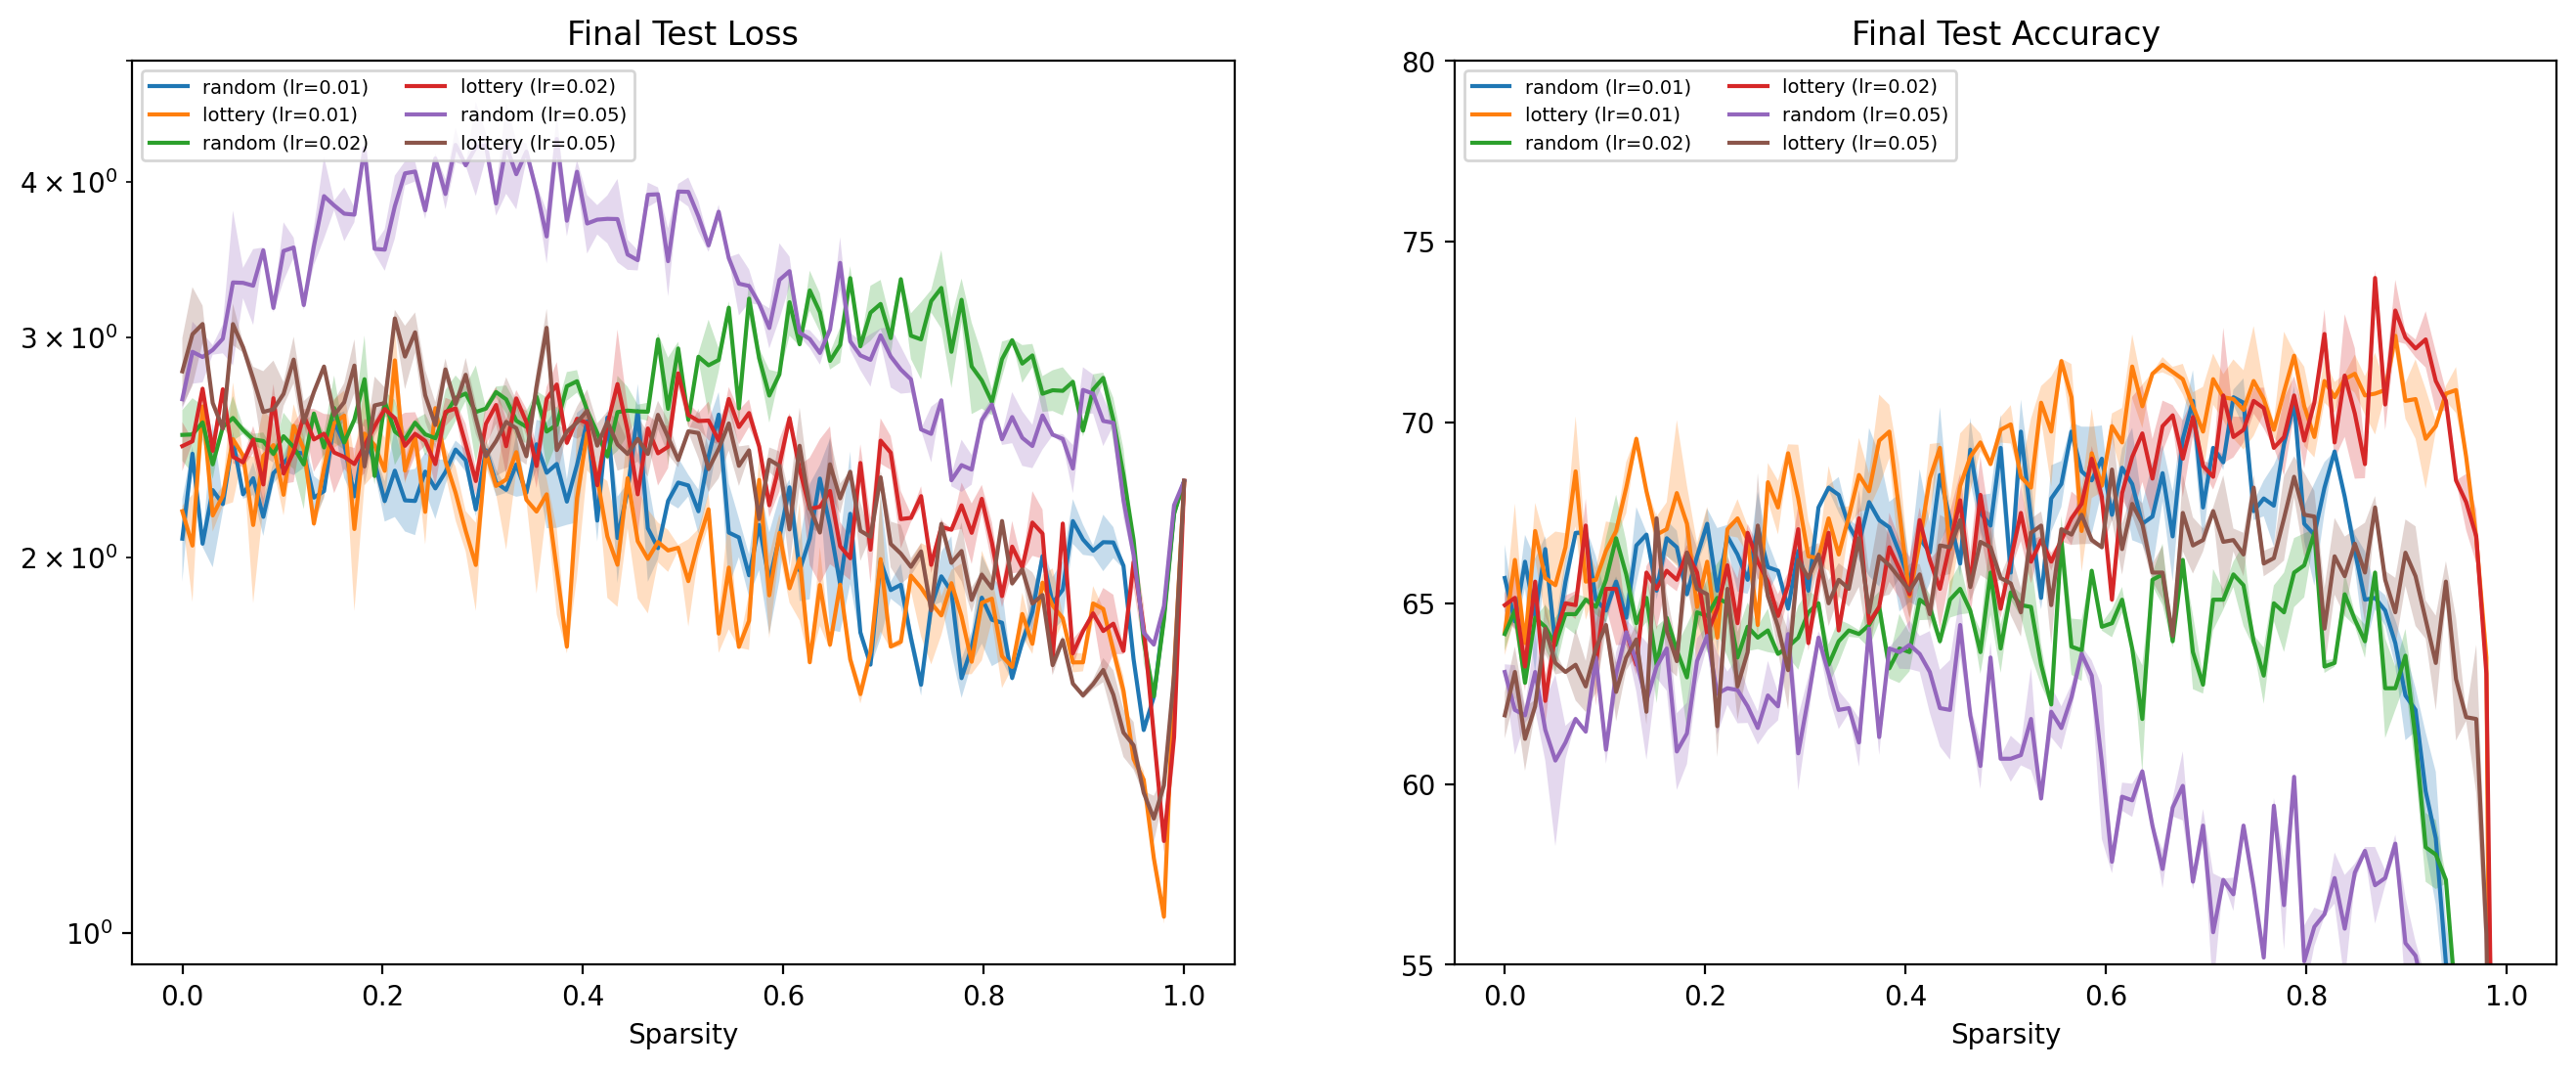

In [ ]:
x = sparsity_schedule
rand_color, lott_color = 'r', 'b'
fig = plt.figure(figsize=[16, 6], dpi=200)

# Plot Final Test Loss for Different Learning Rates
plt.subplot(1, 2, 1)
for lr, trials in all_trials.items():
    for trial_name, color, label in zip(['rand_stats', 'lott_stats'], [rand_color, lott_color], ['random', 'lottery']):
        y, y_err = average_over(trials, trial_name, 'test_losses')
        y, y_err = y[:, -1], y_err[:, -1]
        plt.plot(x, y, '-', label=f"{label} (lr={lr})")
        plt.fill_between(x, y - y_err, y + y_err, alpha=0.25)

plt.xlabel('Sparsity')
plt.title('Final Test Loss')
plt.yscale('log')
plt.ylim(None, 5e0)
plt.legend(fontsize=7, ncol=2, loc='upper left')

# Plot Final Test Accuracy for Different Learning Rates
plt.subplot(1, 2, 2)
for lr, trials in all_trials.items():
    for trial_name, color, label in zip(['rand_stats', 'lott_stats'], [rand_color, lott_color], ['random', 'lottery']):
        y, y_err = average_over(trials, trial_name, 'test_accs')
        y, y_err = y[:, -1], y_err[:, -1]
        plt.plot(x, y, '-', label=f"{label} (lr={lr})")
        plt.fill_between(x, y - y_err, y + y_err, alpha=0.25)

plt.xlabel('Sparsity')
plt.title('Final Test Accuracy')
plt.ylim(55, 80)
plt.legend(fontsize=7, ncol=2, loc='upper left')

plt.show()
